In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
from tensorflow.keras import layers, Model, Input
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report

In [2]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Image Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=10, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest')

# Validation data should not have augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training, validation and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=16,
    subset='training',
    class_mode='categorical')
val_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=16,
    subset='validation',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=1, 
    class_mode='categorical')


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


The distribution of Dataset is as follows:
1. Train = 4571 images
2. Validation = 1141 images
3. Test = 1311 images

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
                                                    image_size=(224, 224),
                                                    batch_size = 16, 
                                                     # class_mode='categorical',
                                                   shuffle = True)

Found 5712 files belonging to 4 classes.


In [4]:
class_names = train_dataset.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:


def plain_network(num_layers):
    input_shape = (224, 224, 3)

    # Define filter sizes and repetitions for each model
    if num_layers == 18:
        repetitions = [2, 2, 2, 2]  # Layers for each block (64, 128, 256, 512)
        filter_sizes = [64, 128, 256, 512]
    elif num_layers == 34:
        repetitions = [3, 4, 6, 3]  # Layers for each block (64, 128, 256, 512)
        filter_sizes = [64, 128, 256, 512]
    elif num_layers == 40:
        repetitions = [3, 5, 6, 4, 1]  # Adding an extra block with 1024 filters
        filter_sizes = [64, 128, 256, 512, 1024]
    else:
        raise ValueError("Only num_layers=18, 34, or 40 are supported.")

    # Input layer
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Function to create a single block
    def conv_block(x, filters):
        # Standard structure: 3x3 convolutions
        x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    # Build layers based on repetitions and filter sizes
    for i, num_repeats in enumerate(repetitions):
        for _ in range(num_repeats):
            x = conv_block(x, filters=filter_sizes[i])

    # Global Average Pooling and Dense Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1000, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(4, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=predictions)
    return model


# Create and compile models
model_18 = plain_network(num_layers=18)
model_34 = plain_network(num_layers=34)
model_40 = plain_network(num_layers=40)

# Summaries for verification
print("Plain 18-Layer Network:")
model_18.summary()

print("\nPlain 34-Layer Network:")
model_34.summary()

print("\nPlain 40-Layer Network:")
model_40.summary()


Plain 18-Layer Network:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           51

 Total params: 11,531,404 (43.99 MB)

 Trainable params: 11,523,596 (43.96 MB)

 Non-trainable params: 7,808 (30.50 KB)


Plain 34-Layer Network:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 56, 56, 64)     │           25

 Total params: 21,650,700 (82.59 MB)

 Trainable params: 21,635,468 (82.53 MB)

 Non-trainable params: 15,232 (59.50 KB)


Plain 40-Layer Network:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_50 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_51 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_52 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_53 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_54 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_55 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 56, 56, 64)     │           25

 Total params: 41,348,620 (157.73 MB)

 Trainable params: 41,326,732 (157.65 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [6]:
# Compile models
initial_learning_rate = 0.001
learning_rate_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-5)

models_list = [model_18, model_34, model_40]
for model in models_list:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy', 'mse'])



In [7]:
history_list = []
layer_counts = [18, 34, 40]  # Specify the layer counts explicitly
#Batch_Size = 32

for i, (model, layers) in enumerate(zip(models_list, layer_counts), start=1):
    print(f"Training Model with {layers} Layers")
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=30,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )
    history_list.append(history)

    # Save the model with both weights and architecture
    model.save(f"model_{layers}_layers.h5")  # Save with appropriate naming (e.g., model_18_layers.h5)


Training Model with 18 Layers
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731859461.961555     123 service.cc:145] XLA service 0x7cb32c003210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731859461.961606     123 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731859479.366920     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill

188/285 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - accuracy: 0.4587 - loss: 1.1746 - mse: 0.1585

I0000 00:00:1731859544.178472     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



285/285 ━━━━━━━━━━━━━━━━━━━━ 141s 391ms/step - accuracy: 0.4827 - loss: 1.1349 - mse: 0.1534 - val_accuracy: 0.3292 - val_loss: 3.2366 - val_mse: 0.2665
Epoch 2/30
  1/285 ━━━━━━━━━━━━━━━━━━━━ 56s 197ms/step - accuracy: 0.6875 - loss: 0.8150 - mse: 0.1112

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6875 - loss: 0.8150 - mse: 0.1112 - val_accuracy: 0.4000 - val_loss: 3.2935 - val_mse: 0.2415
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 74s 256ms/step - accuracy: 0.6169 - loss: 0.9167 - mse: 0.1262 - val_accuracy: 0.5502 - val_loss: 1.4587 - val_mse: 0.1635
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 166us/step - accuracy: 0.7500 - loss: 0.6615 - mse: 0.0981 - val_accuracy: 0.6000 - val_loss: 0.5258 - val_mse: 0.0925
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 73s 251ms/step - accuracy: 0.6496 - loss: 0.8505 - mse: 0.1167 - val_accuracy: 0.2940 - val_loss: 32.5519 - val_mse: 0.3331
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 162us/step - accuracy: 0.6875 - loss: 0.6440 - mse: 0.0914 - val_accuracy: 0.6000 - val_loss: 2.2009 - val_mse: 0.1613
Epoch 7/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 81s 249ms/step - accuracy: 0.6710 - loss: 0.7836 - mse: 0.1081 - val_accuracy: 0.5960 - val_loss: 0.9803 - val_mse: 0.1325
Epoch 8/30
285/285 ━━━━━━━━━━━━━━━━━━

I0000 00:00:1731860663.100606     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads



239/285 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - accuracy: 0.4383 - loss: 1.1579 - mse: 0.1542

I0000 00:00:1731860763.102819     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads



285/285 ━━━━━━━━━━━━━━━━━━━━ 164s 468ms/step - accuracy: 0.4435 - loss: 1.1524 - mse: 0.1537 - val_accuracy: 0.2764 - val_loss: 12.0129 - val_mse: 0.3588
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 0.8628 - mse: 0.1127 - val_accuracy: 0.2000 - val_loss: 9.4222 - val_mse: 0.3991
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 123s 427ms/step - accuracy: 0.5291 - loss: 1.0274 - mse: 0.1396 - val_accuracy: 0.4067 - val_loss: 1.3609 - val_mse: 0.1864
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.6250 - loss: 0.8413 - mse: 0.1179 - val_accuracy: 0.2000 - val_loss: 1.7553 - val_mse: 0.2551
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 123s 426ms/step - accuracy: 0.5952 - loss: 0.9308 - mse: 0.1282 - val_accuracy: 0.2975 - val_loss: 1.8834 - val_mse: 0.2148
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.7500 - loss: 0.7027 - mse: 0.0992 - val_accuracy: 0.0000e+00 - val_loss: 2.9406 - val_mse: 0.2952
Epoch 7/30
285/285 ━━━━━━━━━━━

I0000 00:00:1731862603.613157     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads



206/285 ━━━━━━━━━━━━━━━━━━━━ 51s 654ms/step - accuracy: 0.4080 - loss: 1.2406 - mse: 0.1645

I0000 00:00:1731862766.208218     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_29', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads



285/285 ━━━━━━━━━━━━━━━━━━━━ 297s 831ms/step - accuracy: 0.4147 - loss: 1.2247 - mse: 0.1626 - val_accuracy: 0.2306 - val_loss: 1.9137 - val_mse: 0.2149
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4375 - loss: 1.2142 - mse: 0.1706 - val_accuracy: 0.4000 - val_loss: 2.7148 - val_mse: 0.2429
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 209s 727ms/step - accuracy: 0.4891 - loss: 1.0537 - mse: 0.1449 - val_accuracy: 0.2315 - val_loss: 2.0173 - val_mse: 0.2107
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - accuracy: 0.5000 - loss: 0.8868 - mse: 0.1274 - val_accuracy: 0.4000 - val_loss: 1.7652 - val_mse: 0.1975
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 209s 730ms/step - accuracy: 0.5333 - loss: 0.9872 - mse: 0.1363 - val_accuracy: 0.2799 - val_loss: 40.6909 - val_mse: 0.3600
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - accuracy: 0.3125 - loss: 1.1652 - mse: 0.1644 - val_accuracy: 0.2000 - val_loss: 56.4234 - val_mse: 0.4000
Epoch 7/30
285/285 ━━━━━━━━━━━━━

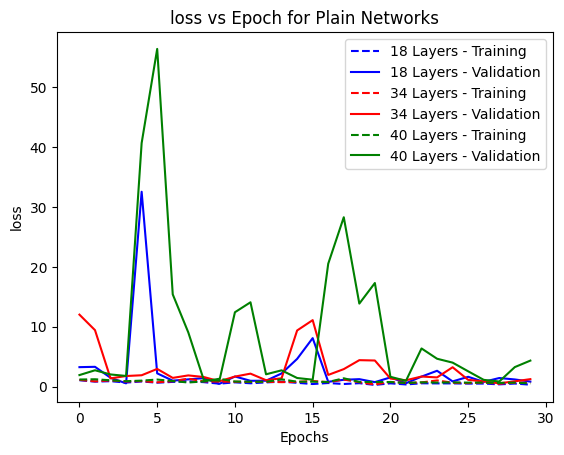

In [8]:
import matplotlib.pyplot as plt

# Plot error vs epoch for each model
def plot_error_vs_epoch(history_list, layer_counts):
    colors = ['blue', 'red', 'green']  # Define colors for the models
    for i, (history, layers) in enumerate(zip(history_list, layer_counts)):
        color = colors[i % len(colors)]  # Assign color for the current model
        plt.plot(
            history.history['loss'], 
            color=color, linestyle='--', label=f'{layers} Layers - Training'
        )
        plt.plot(
            history.history['val_loss'], 
            color=color, linestyle='-', ms = 0.2, label=f'{layers} Layers - Validation'
        )
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.title("loss vs Epoch for Plain Networks")
    plt.show()

# Call the function to plot
plot_error_vs_epoch(history_list, layer_counts)


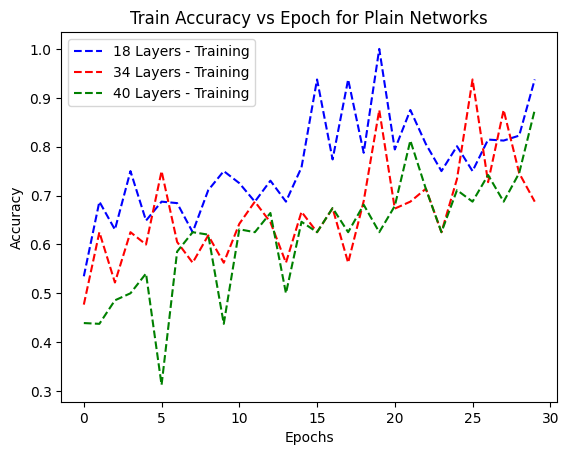

In [25]:
import matplotlib.pyplot as plt

# Plot error vs epoch for each model
def plot_error_vs_epoch(history_list, layer_counts):
    colors = ['blue', 'red', 'green']  # Define colors for the models
    for i, (history, layers) in enumerate(zip(history_list, layer_counts)):
        color = colors[i % len(colors)]  # Assign color for the current model
        plt.plot(
            history.history['accuracy'], 
            color=color, linestyle='--', label=f'{layers} Layers - Training'
        )
        
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Train Accuracy vs Epoch for Plain Networks")
    plt.show()

# Call the function to plot
plot_error_vs_epoch(history_list, layer_counts)


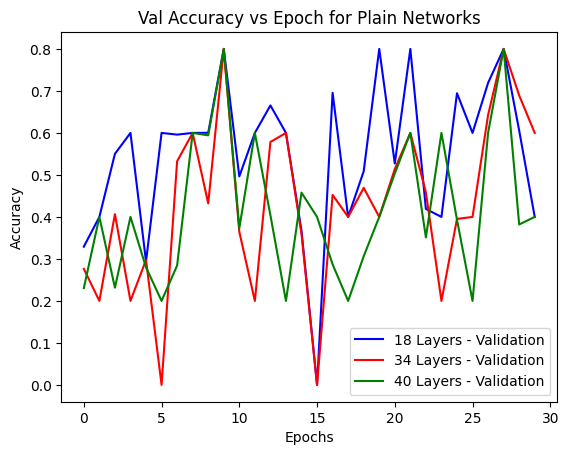

In [26]:
import matplotlib.pyplot as plt

# Plot error vs epoch for each model
def plot_error_vs_epoch(history_list, layer_counts):
    colors = ['blue', 'red', 'green']  # Define colors for the models
    for i, (history, layers) in enumerate(zip(history_list, layer_counts)):
        color = colors[i % len(colors)]  # Assign color for the current model
        plt.plot(
            history.history['val_accuracy'], 
            color=color, linestyle='-', ms = 0.2, label=f'{layers} Layers - Validation'
        )
        
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Val Accuracy vs Epoch for Plain Networks")
    plt.show()

# Call the function to plot
plot_error_vs_epoch(history_list, layer_counts)


In [23]:
import pickle

# Save the history_list to a file
with open('history_list.pkl', 'wb') as file:
    pickle.dump(history_list, file)

print("history_list saved successfully!")


history_list saved successfully!


In [24]:
# Load the history_list from the file
with open('/kaggle/working/history_list.pkl', 'rb') as file:
    history_list_loaded = pickle.load(file)

print("history_list loaded successfully!")


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 74 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 138 variables whereas the saved optimizer has 274 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


history_list loaded successfully!


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 162 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:
# Trying to understand the saved model history structure
for i, history in enumerate(history_list_loaded):
    print(f"Model {i + 1} Training Accuracy: {history.history['accuracy']}")
    print(f"Model {i + 1} Validation Accuracy: {history.history['val_accuracy']}")


Model 1 Training Accuracy: [0.483863890171051, 0.375, 0.5615806579589844, 0.5625, 0.636663019657135, 0.75, 0.6873764991760254, 0.625, 0.7053787112236023, 0.75, 0.7192096710205078, 0.6875, 0.7339187860488892, 0.8125, 0.7466520071029663, 0.625, 0.7574094533920288, 0.75, 0.7732162475585938, 0.75]
Model 1 Validation Accuracy: [0.42517605423927307, 0.6000000238418579, 0.6294013857841492, 0.800000011920929, 0.28433099389076233, 0.20000000298023224, 0.45158451795578003, 0.4000000059604645, 0.4964788854122162, 0.6000000238418579, 0.6179577708244324, 0.20000000298023224, 0.6320422291755676, 0.6000000238418579, 0.5880281925201416, 0.4000000059604645, 0.5193662047386169, 0.4000000059604645, 0.6716549396514893, 0.4000000059604645]
Model 2 Training Accuracy: [0.4623490571975708, 0.5625, 0.5661910176277161, 0.625, 0.5765093564987183, 0.625, 0.61800217628479, 0.6875, 0.6256860494613647, 0.6875, 0.6456640958786011, 0.625, 0.6395170092582703, 0.625, 0.6564215421676636, 0.75, 0.6566410660743713, 0.5625,

In [ ]:
# After training, I am loading all the three models and testing one by one, the results of all the models can be seen in the report.

In [21]:
#loading the model
model = load_model("/kaggle/working/model_40_layers.h5")

In [22]:
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = next(test_generator)
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

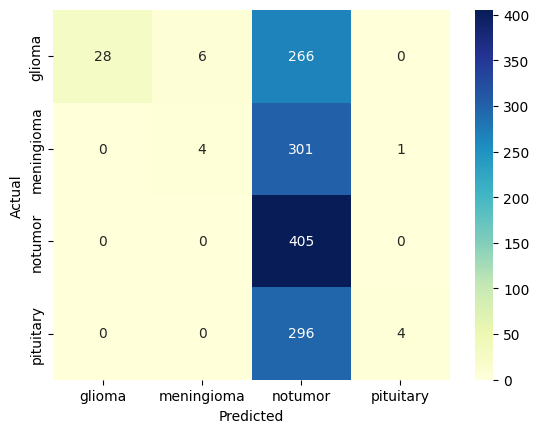

test accuracy: 33.63844393592677


In [23]:
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [24]:
score = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
report = classification_report(
	actual_class, 
	predicted_class,
	target_names=class_names,digits=4 )


print(report)

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.3334 - loss: 5.5862 - mean_squared_error: 0.3118
Test Loss: 5.407310962677002, Test Accuracy: 0.33638444542884827
              precision    recall  f1-score   support

      glioma     1.0000    0.0933    0.1707       300
  meningioma     0.4000    0.0131    0.0253       306
     notumor     0.3194    1.0000    0.4842       405
   pituitary     0.8000    0.0133    0.0262       300

    accuracy                         0.3364      1311
   macro avg     0.6299    0.2799    0.1766      1311
weighted avg     0.6039    0.3364    0.2005      1311



# **Training after Remediation:**

1. Reduced Learning rate from 0.001 to 0.0001 and minimum learning rate from 10^-5 to 10^-6.
2. Performed Gradient Clipping: Cap gradients to a maximum norm or value to prevent them from growing too larger

In [29]:


def plain_network(num_layers):
    input_shape = (224, 224, 3)

    # Define filter sizes and repetitions for each model
    if num_layers == 18:
        repetitions = [2, 2, 2, 2]  # Layers for each block (64, 128, 256, 512)
        filter_sizes = [64, 128, 256, 512]
    elif num_layers == 34:
        repetitions = [3, 4, 6, 3]  # Layers for each block (64, 128, 256, 512)
        filter_sizes = [64, 128, 256, 512]
    elif num_layers == 40:
        repetitions = [3, 5, 6, 4, 1]  # Adding an extra block with 1024 filters
        filter_sizes = [64, 128, 256, 512, 1024]
    else:
        raise ValueError("Only num_layers=18, 34, or 40 are supported.")

    # Input layer
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Function to create a single block
    def conv_block(x, filters):
        # Standard structure: 3x3 convolutions
        x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    # Build layers based on repetitions and filter sizes
    for i, num_repeats in enumerate(repetitions):
        for _ in range(num_repeats):
            x = conv_block(x, filters=filter_sizes[i])

    # Global Average Pooling and Dense Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1000, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(4, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=predictions)
    return model


# Create and compile models
model_18 = plain_network(num_layers=18)
model_34 = plain_network(num_layers=34)
model_40 = plain_network(num_layers=40)

# Summaries for verification
print("Plain 18-Layer Network:")
model_18.summary()

print("\nPlain 34-Layer Network:")
model_34.summary()

print("\nPlain 40-Layer Network:")
model_40.summary()





Plain 18-Layer Network:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_89 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_90 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_91 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_92 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_93 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_94 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 56, 56, 128)    │           51

 Total params: 11,531,404 (43.99 MB)

 Trainable params: 11,523,596 (43.96 MB)

 Non-trainable params: 7,808 (30.50 KB)


Plain 34-Layer Network:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_106 (ReLU)                │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_107 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_108 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_109 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_110 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_111 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 56, 56, 64)     │           25

 Total params: 21,650,700 (82.59 MB)

 Trainable params: 21,635,468 (82.53 MB)

 Non-trainable params: 15,232 (59.50 KB)


Plain 40-Layer Network:


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_139         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_139 (ReLU)                │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_140         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_140 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_141         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_141 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_142         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_142 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_143         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_143 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_144 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_144         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_144 (ReLU)                │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_145         │ (None, 56, 56, 64)     │           25

 Total params: 41,348,620 (157.73 MB)

 Trainable params: 41,326,732 (157.65 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [33]:
# Compile models
initial_learning_rate = 0.00008
learning_rate_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)

models_list = [model_18, model_34, model_40]
for model in models_list:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm = 1.0),
                  loss='categorical_crossentropy', metrics=['accuracy', 'mse'])


In [34]:
history_list = []
layer_counts = [18, 34, 40]  # we choose these three versions of the model
#Batch_Size = 32

for i, (model, layers) in enumerate(zip(models_list, layer_counts), start=1):
    print(f"Training Model with {layers} Layers")
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=30,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )
    history_list.append(history)

    # Save the model with both weights and architecture
    model.save(f"rem_model_{layers}_layers.h5")  # Save with appropriate naming (e.g., model_18_layers.h5)

Training Model with 18 Layers
Epoch 1/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 103s 287ms/step - accuracy: 0.8666 - loss: 0.3763 - mse: 0.0491 - val_accuracy: 0.6875 - val_loss: 1.4975 - val_mse: 0.1280
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.4454 - mse: 0.0500 - val_accuracy: 0.8000 - val_loss: 0.5119 - val_mse: 0.0806
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 73s 252ms/step - accuracy: 0.8925 - loss: 0.3201 - mse: 0.0416 - val_accuracy: 0.4780 - val_loss: 3.3635 - val_mse: 0.2380
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 164us/step - accuracy: 0.8750 - loss: 0.3060 - mse: 0.0470 - val_accuracy: 0.8000 - val_loss: 1.4895 - val_mse: 0.0999
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 72s 249ms/step - accuracy: 0.8929 - loss: 0.3102 - mse: 0.0397 - val_accuracy: 0.7975 - val_loss: 0.5744 - val_mse: 0.0748
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 161us/step - accuracy: 1.0000 - loss: 0.0815 - mse: 0.0069 - val_accuracy: 0.4000 - val_loss: 1.8790 - val_mse: 0.2

I0000 00:00:1731870388.842364     125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_72', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_66', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_65', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_63', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_52', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_51', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_49', 

233/285 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - accuracy: 0.5363 - loss: 1.0292 - mse: 0.1387

I0000 00:00:1731870493.738439     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_81', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_74', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_63', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_52', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_51',

285/285 ━━━━━━━━━━━━━━━━━━━━ 181s 494ms/step - accuracy: 0.5510 - loss: 1.0065 - mse: 0.1357 - val_accuracy: 0.2394 - val_loss: 2.6839 - val_mse: 0.2771
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.7198 - mse: 0.0956 - val_accuracy: 0.0000e+00 - val_loss: 3.2160 - val_mse: 0.3370
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 123s 428ms/step - accuracy: 0.7130 - loss: 0.7228 - mse: 0.0977 - val_accuracy: 0.6171 - val_loss: 1.0765 - val_mse: 0.1345
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - accuracy: 0.4375 - loss: 1.3835 - mse: 0.1957 - val_accuracy: 0.4000 - val_loss: 2.3416 - val_mse: 0.2601
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 124s 428ms/step - accuracy: 0.7770 - loss: 0.5868 - mse: 0.0788 - val_accuracy: 0.4199 - val_loss: 3.9675 - val_mse: 0.2337
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - accuracy: 0.7500 - loss: 0.5677 - mse: 0.0717 - val_accuracy: 0.6000 - val_loss: 1.9897 - val_mse: 0.1374
Epoch 7/30
285/285 ━━━━━━━━━━━━

I0000 00:00:1731872315.797744     125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_79', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_72', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_71', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_69', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_67'

 88/285 ━━━━━━━━━━━━━━━━━━━━ 2:10 665ms/step - accuracy: 0.4929 - loss: 1.1363 - mse: 0.1514

I0000 00:00:1731872393.673387     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_79', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_77', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_76', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_71', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_70', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_69',

285/285 ━━━━━━━━━━━━━━━━━━━━ 278s 812ms/step - accuracy: 0.5278 - loss: 1.0709 - mse: 0.1443 - val_accuracy: 0.1215 - val_loss: 1.7450 - val_mse: 0.2298
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8125 - loss: 0.6739 - mse: 0.0884 - val_accuracy: 0.0000e+00 - val_loss: 1.9656 - val_mse: 0.2509
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 210s 734ms/step - accuracy: 0.6867 - loss: 0.7574 - mse: 0.1037 - val_accuracy: 0.4657 - val_loss: 2.0639 - val_mse: 0.2035
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - accuracy: 0.8750 - loss: 0.4590 - mse: 0.0534 - val_accuracy: 0.6000 - val_loss: 1.7176 - val_mse: 0.1918
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 211s 734ms/step - accuracy: 0.7492 - loss: 0.6494 - mse: 0.0882 - val_accuracy: 0.3143 - val_loss: 13.5204 - val_mse: 0.3336
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.6250 - loss: 0.6382 - mse: 0.0917 - val_accuracy: 0.2000 - val_loss: 20.1001 - val_mse: 0.3969
Epoch 7/30
285/285 ━━━━━━━━━━

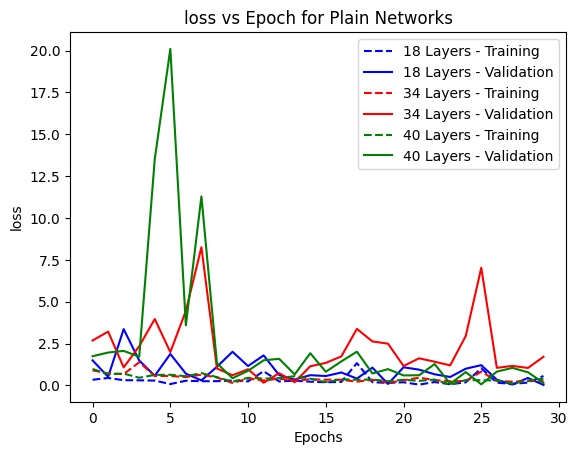

In [35]:
import matplotlib.pyplot as plt

# Plot error vs epoch for each model
def plot_error_vs_epoch(history_list, layer_counts):
    colors = ['blue', 'red', 'green']  # Defining colors for the models
    for i, (history, layers) in enumerate(zip(history_list, layer_counts)):
        color = colors[i % len(colors)]  # Assigning color for the current model
        plt.plot(
            history.history['loss'], 
            color=color, linestyle='--', label=f'{layers} Layers - Training'
        )
        plt.plot(
            history.history['val_loss'], 
            color=color, linestyle='-', ms = 0.2, label=f'{layers} Layers - Validation'
        )
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.title("loss vs Epoch for Plain Networks")
    plt.show()

# Calling the function to plot
plot_error_vs_epoch(history_list, layer_counts)


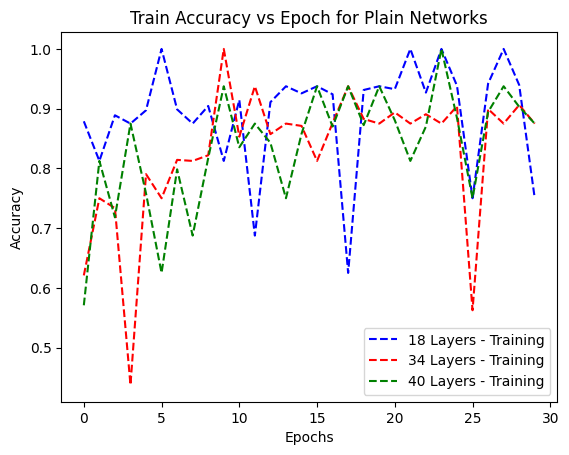

In [36]:


# Ploting error vs epoch for each model
def plot_error_vs_epoch(history_list, layer_counts):
    colors = ['blue', 'red', 'green']  # Defining colors for the models
    for i, (history, layers) in enumerate(zip(history_list, layer_counts)):
        color = colors[i % len(colors)]  # Assigning color for the current model
        plt.plot(
            history.history['accuracy'], 
            color=color, linestyle='--', label=f'{layers} Layers - Training'
        )
        
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Train Accuracy vs Epoch for Plain Networks")
    plt.show()

# Calling the function to plot
plot_error_vs_epoch(history_list, layer_counts)

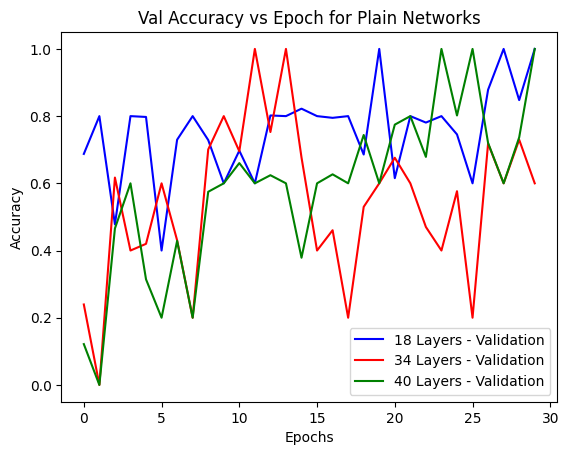

In [37]:


# Plot error vs epoch for each model
def plot_error_vs_epoch(history_list, layer_counts):
    colors = ['blue', 'red', 'green']  # Define colors for the models
    for i, (history, layers) in enumerate(zip(history_list, layer_counts)):
        color = colors[i % len(colors)]  # Assign color for the current model
        plt.plot(
            history.history['val_accuracy'], 
            color=color, linestyle='-', ms = 0.2, label=f'{layers} Layers - Validation'
        )
        
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Val Accuracy vs Epoch for Plain Networks")
    plt.show()

# Call the function to plot
plot_error_vs_epoch(history_list, layer_counts)



In [46]:
#loading the model

model = load_model("/kaggle/working/rem_model_40_layers.h5")

In [47]:
# Finding the predictor labels to compare with original test labels for confusion matrix
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = next(test_generator)
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

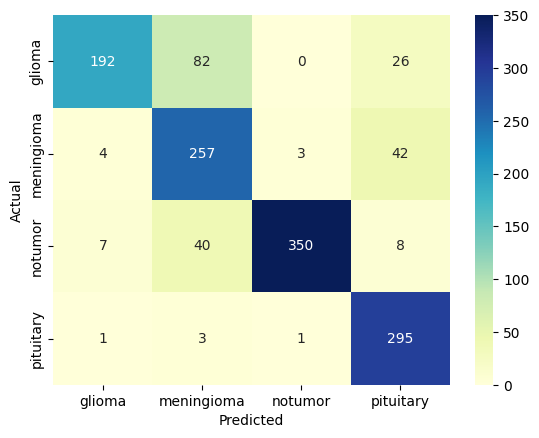

test accuracy: 83.44774980930588


In [48]:

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))



In [49]:
score = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
report = classification_report(
	actual_class, 
	predicted_class,
	target_names=class_names,digits=4 )


print(report)

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.8336 - loss: 0.5002 - mean_squared_error: 0.0644
Test Loss: 0.5089516639709473, Test Accuracy: 0.8344774842262268
              precision    recall  f1-score   support

      glioma     0.9412    0.6400    0.7619       300
  meningioma     0.6728    0.8399    0.7471       306
     notumor     0.9887    0.8642    0.9223       405
   pituitary     0.7951    0.9833    0.8793       300

    accuracy                         0.8345      1311
   macro avg     0.8495    0.8319    0.8276      1311
weighted avg     0.8598    0.8345    0.8348      1311



**Residual Network**

In [50]:
from tensorflow.keras import layers, Model, Input
import tensorflow as tf

def residual_network(num_layers):
    input_shape = (224, 224, 3)

    # Define filter sizes and repetitions for each model
    if num_layers == 18:
        repetitions = [2, 2, 2, 2]  # Layers for each block (64, 128, 256, 512)
        filter_sizes = [64, 128, 256, 512]
    elif num_layers == 34:
        repetitions = [3, 4, 6, 3]  # Layers for each block (64, 128, 256, 512)
        filter_sizes = [64, 128, 256, 512]
    elif num_layers == 40:
        repetitions = [3, 5, 6, 4, 1]  # Adding an extra block with 1024 filters
        filter_sizes = [64, 128, 256, 512, 1024]
    else:
        raise ValueError("Only num_layers=18, 34, or 40 are supported.")

    # Input layer
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Function to create a single residual block
    def residual_block(x, filters, downsample=False):
        identity = x  # Save the input tensor for the skip connection

        # Downsample if needed (e.g., stride > 1 or filter size changes)
        if downsample:
            identity = layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')(identity)
            identity = layers.BatchNormalization()(identity)

        # Main path
        stride = 2 if downsample else 1
        x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Add the skip connection
        x = layers.Add()([x, identity])
        x = layers.ReLU()(x)

        return x

    # Build layers based on repetitions and filter sizes
    for i, num_repeats in enumerate(repetitions):
        for j in range(num_repeats):
            if j == 0 and i > 0:  # Apply downsampling at the start of a new block
                x = residual_block(x, filters=filter_sizes[i], downsample=True)
            else:
                x = residual_block(x, filters=filter_sizes[i])

    # Global Average Pooling and Dense Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1000, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(4, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=predictions)
    return model

# Create and compile models
model_18 = residual_network(num_layers=18)
model_34 = residual_network(num_layers=34)
model_40 = residual_network(num_layers=40)

# Summaries for verification
print("Residual 18-Layer Network:")
model_18.summary()

print("\nResidual 34-Layer Network:")
model_34.summary()

print("\nResidual 40-Layer Network:")
model_40.summary()


Residual 18-Layer Network:


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_178 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_178[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_178 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 56, 56,    │          0 │ re_lu_178[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_179[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_179 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_179[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_180[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_180 (ReLU)    │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_181 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_180[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_181[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_181 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_182 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_181[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_182[0][0]

 Total params: 11,707,916 (44.66 MB)

 Trainable params: 11,698,316 (44.63 MB)

 Non-trainable params: 9,600 (37.50 KB)


Residual 34-Layer Network:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_198 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_198[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_195 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ re_lu_195[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_199 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_199[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_196 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_200 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_196[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_200[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_197 (ReLU)    │ (None, 56, 56,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_201 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_197[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_201[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_198 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_202 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_198[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_202[0][0]

 Total params: 21,827,212 (83.26 MB)

 Trainable params: 21,810,188 (83.20 MB)

 Non-trainable params: 17,024 (66.50 KB)


Residual 40-Layer Network:


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_234 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_234[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_228 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 56, 56,    │          0 │ re_lu_228[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_235 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_235[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_229 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_236 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_229[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_236[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_230 (ReLU)    │ (None, 56, 56,    │          0 │ add_24[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_237 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_230[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_237[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_231 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_238 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_231[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_238[0][0]

 Total params: 42,054,540 (160.43 MB)

 Trainable params: 42,028,812 (160.33 MB)

 Non-trainable params: 25,728 (100.50 KB)

In [51]:
# Compile models
initial_learning_rate = 0.00008
learning_rate_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)

models_list = [model_18, model_34, model_40]
for model in models_list:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm = 1.0),
                  loss='categorical_crossentropy', metrics=['accuracy', 'mse'])


In [52]:
history_list = []
layer_counts = [18, 34, 40]  # Specify the layer counts explicitly
#Batch_Size = 32

for i, (model, layers) in enumerate(zip(models_list, layer_counts), start=1):
    print(f"Training Model with {layers} Layers")
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=30,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )
    history_list.append(history)

    # Save the model with both weights and architecture
    model.save(f"skip_model_{layers}_layers.h5")  # Save with appropriate naming (e.g., model_18_layers.h5)

Training Model with 18 Layers
Epoch 1/30
  1/285 ━━━━━━━━━━━━━━━━━━━━ 2:15:17 29s/step - accuracy: 0.2500 - loss: 1.7952 - mse: 0.2106

I0000 00:00:1731877187.439146     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_38', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_37', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_36', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_33', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_32', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_31'

280/285 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.5882 - loss: 1.0092 - mse: 0.1340

I0000 00:00:1731877257.210167     126 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_38', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_37', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_36', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_33', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_32', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_31'

285/285 ━━━━━━━━━━━━━━━━━━━━ 115s 303ms/step - accuracy: 0.5897 - loss: 1.0057 - mse: 0.1336 - val_accuracy: 0.2623 - val_loss: 3.7627 - val_mse: 0.3339
Epoch 2/30
  1/285 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6875 - loss: 1.3084 - mse: 0.1345

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6875 - loss: 1.3084 - mse: 0.1345 - val_accuracy: 0.2000 - val_loss: 4.3848 - val_mse: 0.3692
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 68s 233ms/step - accuracy: 0.7855 - loss: 0.5650 - mse: 0.0764 - val_accuracy: 0.3671 - val_loss: 2.0345 - val_mse: 0.2293
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.8750 - loss: 0.3363 - mse: 0.0483 - val_accuracy: 0.8000 - val_loss: 0.6472 - val_mse: 0.0857
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 67s 232ms/step - accuracy: 0.8381 - loss: 0.4755 - mse: 0.0606 - val_accuracy: 0.6241 - val_loss: 1.0784 - val_mse: 0.1305
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 92us/step - accuracy: 0.8750 - loss: 0.5844 - mse: 0.0640 - val_accuracy: 0.6000 - val_loss: 0.6599 - val_mse: 0.1196
Epoch 7/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 67s 232ms/step - accuracy: 0.8595 - loss: 0.3932 - mse: 0.0518 - val_accuracy: 0.3257 - val_loss: 6.1772 - val_mse: 0.2938
Epoch 8/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 

I0000 00:00:1731878289.397755     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_79', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_76', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_66', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_60', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_58', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_57',

 37/285 ━━━━━━━━━━━━━━━━━━━━ 3:04 742ms/step - accuracy: 0.3989 - loss: 1.3501 - mse: 0.1756

I0000 00:00:1731878316.120977     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_70', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_69', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_68', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_67', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_64', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_63', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_61'

285/285 ━━━━━━━━━━━━━━━━━━━━ 138s 313ms/step - accuracy: 0.5356 - loss: 1.0986 - mse: 0.1447 - val_accuracy: 0.1461 - val_loss: 2.9988 - val_mse: 0.3068
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5625 - loss: 0.7094 - mse: 0.1126 - val_accuracy: 0.0000e+00 - val_loss: 1.8642 - val_mse: 0.2995
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 98s 235ms/step - accuracy: 0.7594 - loss: 0.6372 - mse: 0.0848 - val_accuracy: 0.5062 - val_loss: 2.3866 - val_mse: 0.2019
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 116us/step - accuracy: 0.8125 - loss: 0.4822 - mse: 0.0711 - val_accuracy: 0.4000 - val_loss: 3.8161 - val_mse: 0.2721
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 68s 234ms/step - accuracy: 0.8024 - loss: 0.5240 - mse: 0.0705 - val_accuracy: 0.5907 - val_loss: 1.2424 - val_mse: 0.1593
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step - accuracy: 0.6875 - loss: 0.7128 - mse: 0.1078 - val_accuracy: 0.8000 - val_loss: 0.8481 - val_mse: 0.0801
Epoch 7/30
285/285 ━━━━━━━━━━━━━━

I0000 00:00:1731879427.690083     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_79', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_72', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_71', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_68', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_67'

235/285 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.5265 - loss: 1.1097 - mse: 0.1463

I0000 00:00:1731879497.086553     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_79', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_75', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_72', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_71', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_69'

285/285 ━━━━━━━━━━━━━━━━━━━━ 149s 336ms/step - accuracy: 0.5426 - loss: 1.0813 - mse: 0.1425 - val_accuracy: 0.1646 - val_loss: 7.6689 - val_mse: 0.3730
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7500 - loss: 0.9050 - mse: 0.1021 - val_accuracy: 0.4000 - val_loss: 6.5525 - val_mse: 0.2674
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 88s 239ms/step - accuracy: 0.7610 - loss: 0.6496 - mse: 0.0850 - val_accuracy: 0.4665 - val_loss: 1.9743 - val_mse: 0.2041
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 135us/step - accuracy: 0.6875 - loss: 0.7668 - mse: 0.0958 - val_accuracy: 0.4000 - val_loss: 3.4635 - val_mse: 0.2108
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 68s 235ms/step - accuracy: 0.8103 - loss: 0.5364 - mse: 0.0686 - val_accuracy: 0.6171 - val_loss: 1.2230 - val_mse: 0.1439
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 138us/step - accuracy: 0.8125 - loss: 0.4257 - mse: 0.0592 - val_accuracy: 0.4000 - val_loss: 1.9185 - val_mse: 0.2219
Epoch 7/30
285/285 ━━━━━━━━━━━━━━━━━━

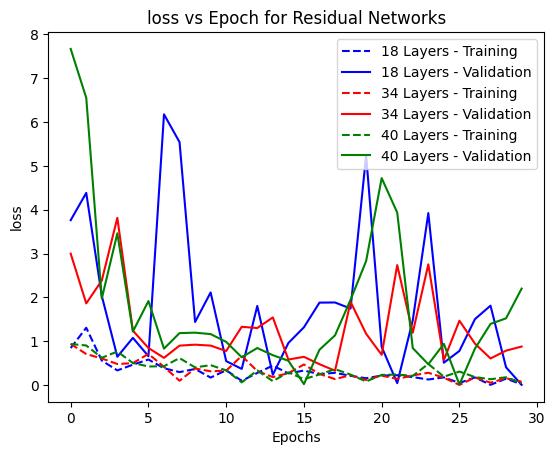

In [53]:
import matplotlib.pyplot as plt

# Plot error vs epoch for each model
def plot_error_vs_epoch(history_list, layer_counts):
    colors = ['blue', 'red', 'green']  # Define colors for the models
    for i, (history, layers) in enumerate(zip(history_list, layer_counts)):
        color = colors[i % len(colors)]  # Assign color for the current model
        plt.plot(
            history.history['loss'], 
            color=color, linestyle='--', label=f'{layers} Layers - Training'
        )
        plt.plot(
            history.history['val_loss'], 
            color=color, linestyle='-', ms = 0.2, label=f'{layers} Layers - Validation'
        )
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.title("loss vs Epoch for Residual Networks")
    plt.show()

# Call the function to plot
plot_error_vs_epoch(history_list, layer_counts)


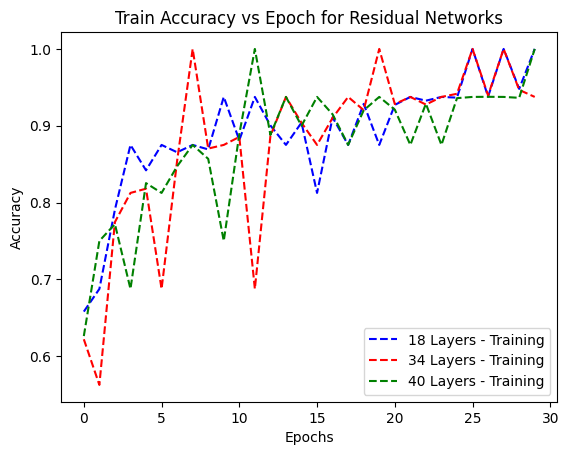

In [54]:


# Plot error vs epoch for each model
def plot_error_vs_epoch(history_list, layer_counts):
    colors = ['blue', 'red', 'green']  # Define colors for the models
    for i, (history, layers) in enumerate(zip(history_list, layer_counts)):
        color = colors[i % len(colors)]  # Assign color for the current model
        plt.plot(
            history.history['accuracy'], 
            color=color, linestyle='--', label=f'{layers} Layers - Training'
        )
        
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Train Accuracy vs Epoch for Residual Networks")
    plt.show()

# Call the function to plot
plot_error_vs_epoch(history_list, layer_counts)



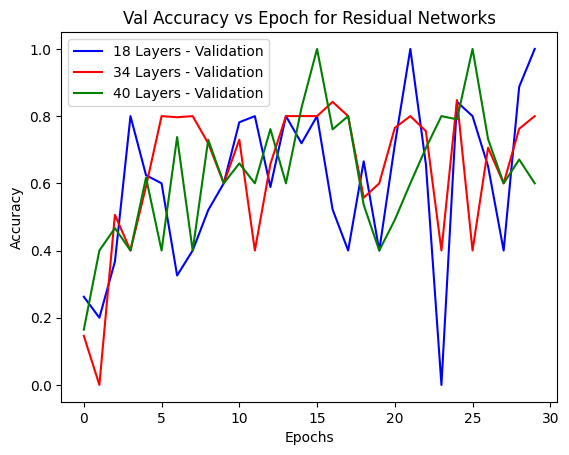

In [55]:
# Plot error vs epoch for each model
def plot_error_vs_epoch(history_list, layer_counts):
    colors = ['blue', 'red', 'green']  # Define colors for the models
    for i, (history, layers) in enumerate(zip(history_list, layer_counts)):
        color = colors[i % len(colors)]  # Assign color for the current model
        plt.plot(
            history.history['val_accuracy'], 
            color=color, linestyle='-', ms = 0.2, label=f'{layers} Layers - Validation'
        )
        
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Val Accuracy vs Epoch for Residual Networks")
    plt.show()

# Call the function to plot
plot_error_vs_epoch(history_list, layer_counts)


In [64]:
#loading the model

model = load_model("/kaggle/working/skip_model_40_layers.h5")

In [65]:
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = next(test_generator)
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

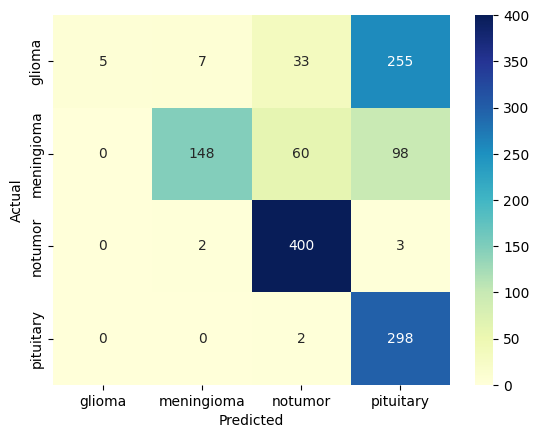

test accuracy: 64.91228070175438


In [67]:
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [63]:
score = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
report = classification_report(
	actual_class, 
	predicted_class,
	target_names=class_names,digits=4 )


print(report)

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8434 - loss: 0.4817 - mean_squared_error: 0.0558
Test Loss: 0.48088324069976807, Test Accuracy: 0.8421052694320679
              precision    recall  f1-score   support

      glioma     1.0000    0.6467    0.7854       300
  meningioma     0.7120    0.8889    0.7907       306
     notumor     0.8326    0.9086    0.8689       405
   pituitary     0.9215    0.9000    0.9106       300

    accuracy                         0.8421      1311
   macro avg     0.8665    0.8360    0.8389      1311
weighted avg     0.8631    0.8421    0.8411      1311

